# Orbital motion
Now we will start on the problem that the Kalman filter was most famously first used for (and the context where I learned it): Orbital motion.  
$$
\def\M#1{{[\mathbf{#1}]}}
\def\MM#1#2{{[\mathbf{#1}{#2}]}}
$$

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
from numpy.linalg import inv

def _inv(x):
    """
    Matrix inverse which also handles scalars properly
    :param x:
    :return:
    """
    try:
        return inv(x)
    except ValueError:
        return np.array([[1.0/x]])



## Problem definition

This is the simplest form of the orbit determination problem I learned this filter on back in school. A satellite is in orbit around a point mass. Newton's gravitation applies. The satellite is tracked from a radar at a fixed point above the point mass (or on the surface of a perfectly smooth, homogeneous, radar-transparent planet) in the plane of the satellite orbit. The point mass is so much heavier than the satellite that we may treat the satellite as a test mass. This means that the gravity of the satellite does not significantly move the central mass, and therefore the mass of the satellite cancels right out of the problem.

## State Vector

This is like the cart, but now we have two dimensions. It is provable that the trajectory of any test mass around a point mass is confined to a plane containing the point mass, as long as it is only under the influence of gravity, or if all other forces are in the plane also.


So, our state vector has four components, two for position and two for velocity, for a total of four.

$$
\vec{x}=\begin{bmatrix}r_x \\ r_y \\ v_x \\ v_y\end{bmatrix}
$$

We are using $r$ instead of $p$ for position, mostly for historical reasons. Think of it as the "ray" or "radius" from the center of mass to the satellite. The names of the components suggest that we can have:

$$\begin{eqnarray*}
\vec{r}&=&\begin{bmatrix}r_x \\ r_y\end{bmatrix}\\
\vec{v}&=&\begin{bmatrix}v_x \\ v_y\end{bmatrix}\\
\end{eqnarray*}$$

We may use this notation when appropriate, meaning that the whole state is the concatenation of these two vectors:

$$
\vec{x}=\begin{bmatrix}\vec{r} \\ - \\ \vec{v}\end{bmatrix}
$$

## Physics

This time we use Newton's Universal Law of Gravitation (in title caps, because it is important.)

$$F=\frac{GMm}{r^2}$$

This is combined with Newton's second law:

$$F=ma$$

to get:

$$ma=\frac{GMm}{r^2}$$

where:

* $F$ is the magnitude of the force on the test mass (only used in this section, above this point, a few times, not to be confused with function $F(\vec{x})$ which is used to describe the rate of change of the state vector).
* $G$ is the universal gravitational constant
* $M$ is the mass of the central mass
* $m$ is the mass of the test mass, $m<<M$
* $r=\sqrt{r_x^2+r_y^2}$ is the distance from the central mass to the test mass
* $a$ is the magnitude of the acceleration imposed on the test mass

We see that m appears on both sides, so we will cancel it out and get:

$$a=\frac{GM}{r^2}$$

Also, this is a vector acceleration, directed towards the center of mass, so multiply this by a unit vector pointing from the test mass to the center $-\vec{r}/r$ to get

$$\vec{a}=\frac{-GM\vec{r}}{r^3}$$

It is very difficult to measure $G$ by itself, as this involves measuring gravity exerted by objects small enough to fit in a laboratory. It is also very difficult to measure $M$ of a planet by itself, because it's a whole planet, and won't fit on a scale. However, by observing the motions of satellites, it turns out that it is easy to accurately measure the product $GM$ much more accurately than either $G$ or $M$. So, we call this product $\mu$ (Greek small mu) and use it instead.

$$\begin{eqnarray*}
F(\vec{x})&=&\vec a \\
                &=&\frac{-\mu\vec r}{r^3}
                \end{eqnarray*}$$

And there's our physics function F(). If we want, we can expand it by element

$$\begin{eqnarray*}
F_{r_x}&=&v_x \\
F_{r_y}&=&v_y \\
F_{v_x}&=&-\frac{\mu r_x}{\left(\sqrt{r_x^2+r_y^2}\right)^3} \\
F_{v_y}&=&-\frac{\mu r_y}{\left(\sqrt{r_x^2+r_y^2}\right)^3} \\
\end{eqnarray*}$$


## Observation

Our radar is able to measure the distance (only) from itself to the satellite. Therefore the measurement vector at any time is just this distance, only one component again. The station is located at $\vec{m}=\begin{bmatrix}m_x & m_y\end{bmatrix}^T$, so the distance from the radar to the satellite is

$$\begin{eqnarray*}
g(\vec{x})&=&\left|\vec{r}-\vec{m}\right| \\
          &=&\sqrt{(r_x-m_x)^2+(r_y-m_y)^2}
\end{eqnarray*}$$

In [2]:
%%capture
%run Covariance.ipynb

## Jacobian matrices

First, $\M \Phi$. This one has a lot of blank space because two of its components are simple variables, and the other two are functions of only two elements of the state vector, so right off we have:

$$
\M \Phi=\begin{bmatrix}0 & 0 & 1 & 0 \\
           0 & 0 & 0 & 1 \\
           \frac{dF_{v_x}}{dr_x} & \frac{dF_{v_x}}{dr_y} & 0 & 0 \\
           \frac{dF_{v_y}}{dr_x} & \frac{dF_{v_y}}{dr_y} & 0 & 0 \end{bmatrix}$$

Only six components out of 16 are nonzero, and only four are nontrivial. So, what about those?

$$
F_{v_x}=-\frac{\mu r_x}{\left(\sqrt{r_x^2+r_y^2}\right)^3}
$$

To the derivinator! [derivative of mu*x/(sqrt(x^2+y^2))^3](http://www.wolframalpha.com/input/?i=derivative+of+mu*x%2F%28sqrt%28x%5E2%2By%5E2%29%29%5E3) I don't think that Alpha is smart enough to substitute r, so I just put it in explicitly, and we can sub it back out when we get the result. Alpha (now I want to call it "Ziggy" for some reason) says that the result is


    (d)/(dx)((mu x)/sqrt(x^2+y^2)^3) = (mu (y^2-2 x^2))/(x^2+y^2)^(5/2)


or cleaning up and putting back in $r=\sqrt{r_x^2+r_y^2}$

$$
\frac{dF_{v_x}}{dr_x}=-\frac{\mu(r_y^2-2r_x^2)}{r^5}
$$


We continue to get the other three elements:

$$
\begin{eqnarray*}
\frac{dF_{v_x}}{dr_y}&=& -\frac{\mu(3r_x r_y)}{r^5} \\
\frac{dF_{v_y}}{dr_x}&=& -\frac{\mu(3r_x r_y)}{r^5} \\
\frac{dF_{v_y}}{dr_y}&=&-\frac{\mu(r_x^2-2r_y^2)}{r^5}
\end{eqnarray*}$$

Note that now that we have the power of Python and SymPy in our corner, we can do something like this:

In [3]:
import sympy
from IPython.display import display
#Symbolic form of physics equations, so that they can be symbolically differentiated
rx,ry,vx,vy,mu=sympy.symbols('r_x r_y v_x v_y mu')
r=sympy.sqrt(rx**2+ry**2)
Frx=vx
Fry=vy
Fvx=-mu*rx/r**3
Fvy=-mu*ry/r**3

In [4]:
def fjac(xsyms,paramsyms,Fsyms):
    """
    Create callable vector functions and Jacobian functions
    from symbolic equations
    :param xsyms    : Tuple or list of symbols for the names of each state vector component
    :param paramsyms: Tuple or list of symbols for the names of each variable used which is not
                      part of the state vector
    :param Fsyms    : Tuple or list of symbolic expressions for each component of the vector formula.
                      There must be a one-to-one correspondence between xsyms and Fsyms, and each
                      component must use only variables in xsyms and paramsyms.
    """
    xmat=sympy.Matrix(xsyms) #Note that these build column matrices out of 1D iterables
    Fmat=sympy.Matrix(Fsyms)
    dFdx=Fmat.jacobian(xmat)
    dFdx=sympy.simplify(dFdx)
    print("State vector: ")
    display(xmat)
    print("Parameters: ")
    display(paramsyms)
    print("Physics Function: ")
    display(Fmat)
    print("Physics Matrix: ")
    display(dFdx)
    #Generate a function from the symbolic equations. The function
    #will have a number of parameters equal to the number of symbols
    #in the vector component list, plus the number of symbols in the
    #parameter list
    if paramsyms is None:
        _F=sympy.lambdify(xsyms          ,Fmat)
    else:
        _F=sympy.lambdify(xsyms+paramsyms,Fmat)
    help(_F)
    #This isn't quite as clean as I had hoped. _jac has to be presented with scalars,
    #because the symbolic math will generate constant terms represented as scalars,
    #which will result in an array which has scalars in some elements and arrays in
    #others. Even a 1-element array will cause a problem, since it makes the whole
    #array no longer a rectangular lattice of numbers. _jac is the big problem, but
    #we call _F the same way.
    def F(x,params=None,t=None):
        """
        Physics function F(<x>). Takes a state vector, returns the derivative of
        the state vector with respect to time. Primary physics model definition
        :param x: state vector or group of state vectors. MUST BE a 2D numpy array,
                  no more, no less, even for a single column vector. Five is right out...
                  Must have exactly as many rows as xsyms. Rows will be passed to _F
                  in one-to-one correspondence to xsyms.
        :param params: Extra parameters to physics function, will be passed in one-to-one
                       correspondence with the paramsyms used to build _F
        :param t: Ignored, but required so this can be called by an ODE solver
        :return: State derivative vector, will be a 2D array the same shape as x.
        """
        result=None
        for i_col,col in enumerate(x.T):
            args=tuple(col)
            if params is not None:
                args=args+tuple(params)
            resultcol=_F(*args).ravel()
            if result is None:
                result=np.zeros((resultcol.size,x.shape[1]))
            result[:,i_col]=resultcol
        return result
    _jac=sympy.lambdify(xsyms+paramsyms,dFdx)
    help(_jac)
    def jac(x,params,t=None):
        """
        Physics matrix [\Phi(<x>)]. Takes a state vector, returns Jacobian of
        the state vector. Secondary physics model definition
        :param x: state vector or group of state vectors. MUST BE a 2D numpy array,
                  no more, no less, even for a single column vector. Five is right out...
                  Must have exactly as many rows as xsyms. Rows will be passed to _F
                  in one-to-one correspondence to xsyms.
        :param params: Extra parameters to physics function, will be passed in one-to-one
                       correspondence with the paramsyms used to build _jac
        :param t: Ignored, but required so this can be called by an ODE solver
        :return: Physics matrix group. Will be a 2D array if x is a single column
                 vector, or else a set with order [i_set,i_row,i_col]. (This index
                 order allows the @ operator to multiply two sets of matrices and
                 return a set of matrices)
        """
        result=None
        for i_col,col in enumerate(x.T):
            args=tuple(col)
            if params is not None:
                args=args+tuple(params)
            resultcol=_jac(*args)
            if result is None:
                result = np.zeros((x.shape[1], )+resultcol.shape)
            result[i_col,:,:]=resultcol
        if result.shape[0]==1:
            result=result[0,:,:]
        return result
    return (F,jac)

(F_B612,Phi_B612)=fjac([rx,ry,vx,vy],[mu],[Frx,Fry,Fvx,Fvy])
xh=np.array([[3,3],[5,5],[0,0],[0,0]])
m=[1000]
#Demonstrate multiplication of stacks of matrices
Phi=Phi_B612(xh,m)
print(Phi@Phi)

State vector: 


Matrix([
[r_x],
[r_y],
[v_x],
[v_y]])

Parameters: 


[mu]

Physics Function: 


Matrix([
[                             v_x],
[                             v_y],
[-mu*r_x/(r_x**2 + r_y**2)**(3/2)],
[-mu*r_y/(r_x**2 + r_y**2)**(3/2)]])

Physics Matrix: 


Matrix([
[                                              0,                                                0, 1, 0],
[                                              0,                                                0, 0, 1],
[mu*(2*r_x**2 - r_y**2)/(r_x**2 + r_y**2)**(5/2),            3*mu*r_x*r_y/(r_x**2 + r_y**2)**(5/2), 0, 0],
[          3*mu*r_x*r_y/(r_x**2 + r_y**2)**(5/2), mu*(-r_x**2 + 2*r_y**2)/(r_x**2 + r_y**2)**(5/2), 0, 0]])

Help on function _lambdifygenerated:

_lambdifygenerated(r_x, r_y, v_x, v_y, mu)
    Created with lambdify. Signature:
    
    func(r_x, r_y, v_x, v_y, mu)
    
    Expression:
    
    Matrix([[v_x], [v_y], [-mu*r_x/(r_x**2 + r_y**2)**(3/2)], [-mu*r_y/(r_x**2...
    
    Source code:
    
    def _lambdifygenerated(r_x, r_y, v_x, v_y, mu):
        return (array([[v_x], [v_y], [-mu*r_x/(r_x**2 + r_y**2)**(3/2)], [-mu*r_y/(r_x**2 + r_y**2)**(3/2)]]))
    
    
    Imported modules:

Help on function _lambdifygenerated:

_lambdifygenerated(r_x, r_y, v_x, v_y, mu)
    Created with lambdify. Signature:
    
    func(r_x, r_y, v_x, v_y, mu)
    
    Expression:
    
    Matrix([[0, 0, 1, 0], [0, 0, 0, 1], [mu*(2*r_x**2 - r_y**2)/(r_x**2 +...
    
    Source code:
    
    def _lambdifygenerated(r_x, r_y, v_x, v_y, mu):
        return (array([[0, 0, 1, 0], [0, 0, 0, 1], [mu*(2*r_x**2 - r_y**2)/(r_x**2 + r_y**2)**(5/2), 3*mu*r_x*r_y/(r_x**2 + r_y**2)**(5/2), 0, 0], [3*mu*r_x*r_y/(r_x**2 + r_

Now for $\M H$. This has four elements, one row for the one element of the observation by four columns for the elements of the state, but two of them are zero since the measurement doesn't involve the velocity elements of the state. We will define $\rho$ (Greek small rho) as the measurement itself, so:

$$\begin{eqnarray*}
\rho&=&g(\vec{x}) \\
    &=&\sqrt{(r_x-m_x)^2+(r_y-m_y)^2}
\end{eqnarray*}$$

$$\begin{eqnarray*}
\frac{dg}{dr_x}&=&\frac{r_x-m_x}{\rho} \\
\frac{dg}{dr_y}&=&\frac{r_y-m_y}{\rho} \\
\end{eqnarray*}$$


In [5]:
mx,my=sympy.symbols('m_x m_y')
rho=sympy.sqrt((rx-mx)**2+(ry-my)**2)
(g_B612,H_B612)=fjac([rx,ry,vx,vy],[mx,my],[rho])

m=[0,1]
print("xh=",xh)
print("g()=",g_B612(xh,m))
print("H()=",H_B612(xh,m))

State vector: 


Matrix([
[r_x],
[r_y],
[v_x],
[v_y]])

Parameters: 


[m_x, m_y]

Physics Function: 


Matrix([[sqrt((-m_x + r_x)**2 + (-m_y + r_y)**2)]])

Physics Matrix: 


Matrix([[(-m_x + r_x)/sqrt((m_x - r_x)**2 + (m_y - r_y)**2), (-m_y + r_y)/sqrt((m_x - r_x)**2 + (m_y - r_y)**2), 0, 0]])

Help on function _lambdifygenerated:

_lambdifygenerated(r_x, r_y, v_x, v_y, m_x, m_y)
    Created with lambdify. Signature:
    
    func(r_x, r_y, v_x, v_y, m_x, m_y)
    
    Expression:
    
    Matrix([[sqrt((-m_x + r_x)**2 + (-m_y + r_y)**2)]])
    
    Source code:
    
    def _lambdifygenerated(r_x, r_y, v_x, v_y, m_x, m_y):
        return (array([[sqrt((-m_x + r_x)**2 + (-m_y + r_y)**2)]]))
    
    
    Imported modules:

Help on function _lambdifygenerated:

_lambdifygenerated(r_x, r_y, v_x, v_y, m_x, m_y)
    Created with lambdify. Signature:
    
    func(r_x, r_y, v_x, v_y, m_x, m_y)
    
    Expression:
    
    Matrix([[(-m_x + r_x)/sqrt((m_x - r_x)**2 + (m_y - r_y)**2), (-m_y +...
    
    Source code:
    
    def _lambdifygenerated(r_x, r_y, v_x, v_y, m_x, m_y):
        return (array([[(-m_x + r_x)/sqrt((m_x - r_x)**2 + (m_y - r_y)**2), (-m_y + r_y)/sqrt((m_x - r_x)**2 + (m_y - r_y)**2), 0, 0]]))
    
    
    Imported modules:

xh= [[3 3]
 [5 5]
 [0 0]
 [0 0]]
g()=

# Worked example

We can hang this model on the same scaffold we built last time. Mostly we just change the model functions, but we are also going to change the simulator at the top, since this model is more complicated than last time.

We are going to orbit planet [B6](https://en.wikipedia.org/wiki/B_612_(The_Little_Prince))[12](http://en.wikipedia.org/wiki/46610_Besixdouze), a perfectly spherical, homogeneous, radar-transparent planet which has a radius of 10m but sufficient gravity to live on conveniently.  The planet has a surface gravity of about 1g, exactly 10m/s^2. 

$$\begin{eqnarray*}
a&=&\frac{\mu}{r^2} \\
ar^2&=&\mu \\
\end{eqnarray*}$$

In [6]:
r_B612=10 #m
a0_B612=10 #m/s**2
mu_B612=a0_B612*r_B612**2
print(mu_B612)

1000


In units of meters and seconds, it has $\mu=1000$, which means that a ball thrown at 10m/s at the surface will stay in a circular orbit right at the surface, and circle the planet in 6.283 seconds.

As an aside, B612 is one weird planet. 

In [7]:
G=6.67430e-11 #Universal gravitational constant, m**3/kg/s**2, CODATA 2018 value
M_B612=mu_B612/G
print("M=%e kg"%M_B612)
V_B612=4/3*np.pi*r_B612**3
rho_B612=M_B612/V_B612
print("V=%f m**3"%V_B612)
print("(water=1000kg/m**3) rho=%e kg/m**3"%rho_B612)

rho_granite=2700 #kg/m**3
comp=6
rho_granite_comp=rho_granite*(9**comp)
print("%d times compressed=%e kg/m**3"%(comp,rho_granite_comp))

M=1.498284e+13 kg
V=4188.790205 m**3
(water=1000kg/m**3) rho=3.576891e+09 kg/m**3
6 times compressed=1.434891e+09 kg/m**3


It needs to weigh almost 15 billion tons to exert this much gravity, and therefore have a density of more than 3 million times that of water -- white dwarf degenerate matter is about 1 million times as dense as water. The object is twice as dense as sextuple compressed cobblestone. And yet it's radar-transparent...

Our program is pretty heavily modified here, so let's look at it fresh again. We use the physics and observation functions and Jacobians defined above, so most of what is below is driver code.

In this first bit, we call a function called ``trueState()`` which we pass in the initial conditions, the timestamps we care about, and the physics function. It then does all the integrating and returns a list of true state vectors at all the requested times.

Note that when we call this function, we pass it a function as a parameter, rather than evaluating the function and passing its result. Function ``trueState()`` will then call that function itself. In this way, we can use the same code to call our own model functions back, so the same framework can support any physics model. The same thing can be done in C with function pointers, in Java with interfaces, and in most truly useful languages in general.

<IPython.core.display.Javascript object>


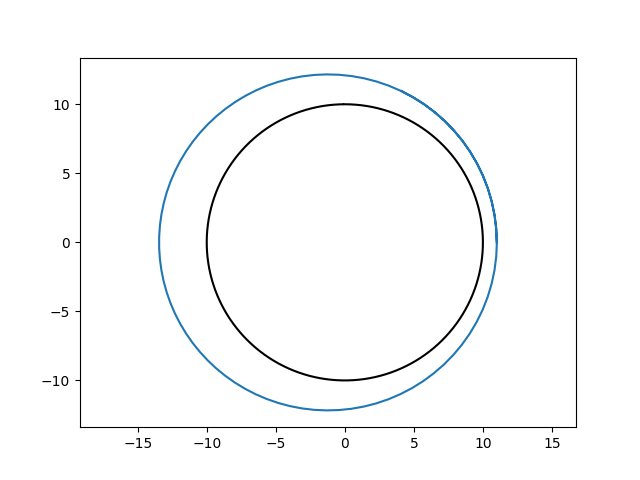

In [8]:
def trueState(t,xt0,F,Fpar,nstep=1000):
    """
    Calculate the true trajectory, given the true initial condition and the physics function F
    """

    xt=np.zeros((xt0.size,t.size)) #True state vector (to be calculated)
    xt[:,0]=xt0.ravel()
    #Do a numerical integrator to get the positions
    for i in range(1,t.size):
        xt_im1=xt[:,i-1].reshape(-1,1)  #Previous true state
        xt_i=xt_im1       #Will contain current true state
        dt=t[i]-t[i-1]
        ddt=dt/nstep;         #Do substeps between measurements
        for j in range(1,nstep):
            #Just use our physics function - that's what it is there for.
            xt_i=xt_i+ddt*F(xt_i,Fpar)
        xt[:,i]=xt_i.ravel();
    return xt

t=np.arange(0,10,0.1)
xt0=np.array([[11],[0],[0],[10]])
xt=trueState(t=t,xt0=xt0,F=F_B612,Fpar=[1000])
import matplotlib.pyplot as plt
plt.figure("True trajectory")
plt.plot(xt[0,:],xt[1,:])
plt.plot(r_B612*np.sin(np.arange(0,6.28,0.01)),r_B612*np.cos(np.arange(0,6.28,0.01)),'k-')
plt.axis('equal')
plt.show()

Next, we call trueObs(), which takes a list of state vectors and the observation function, and produces a list of observations, with noise sprinkled on it if requested. In this case, we call it twice, once with noise and once without, so we can compare the Truth to our estimate.

<IPython.core.display.Javascript object>


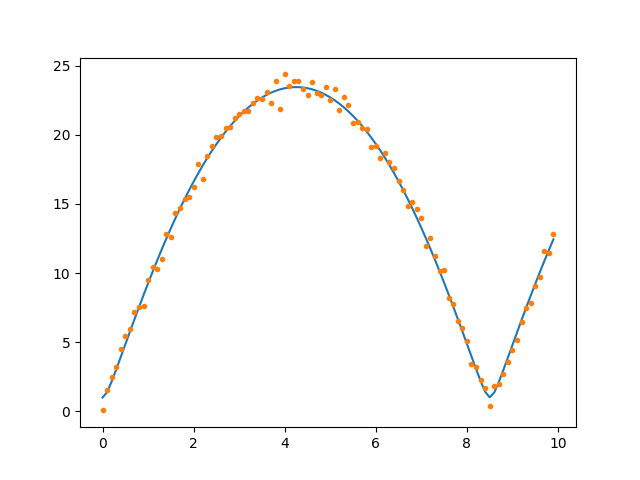

In [9]:
def trueObs(xt,g,gpar,R=None,seed=3217):
    #Size the problem
    s=xt.shape
    n=s[0]
    xt0=xt[:,0].reshape(-1,1)
    z=np.zeros((g(xt0,m).size,s[1]))
    #Clean observations
    for i in range(s[1]):
        z[:,i]=g(xt[:,i].reshape(n,1),gpar).ravel()
  
    #We want random noise, but the *same* random noise each time we run
    if R is not None:
        if seed is not None:
            nr.randn(seed)
        pn=pnoise(s[1],R) #Measurement noise
        z=z+pn            #Noisy Observations
    return z

m=[10,0]
zt=trueObs(xt,g_B612,m)
R=np.array([[0.5**2]])
zn=trueObs(xt,g_B612,m,R)
plt.figure("Observations")
plt.plot(t,zt[0,:],'-')
plt.plot(t,zn[0,:],'.')
plt.show()

To make one time/measurement update, call `ekf_step()`. If you get your measurements one at a time and don't care so much about history, perhaps because you are running a robot control loop, you can call ekf_step() directly. We are going to make this so that you can pass an arbitrary ODE solver.

In order to do so, we will make a wrapper function that smashes a state vector and a state transition matrix into a single augmented state vector. Smashing is easy, unsmashing is a touch more difficult. Any state vector with $n$ elements will have a matching transition matrix of size $n \times n$, for a total of $a=n+n^2$ elements. Solving that equation given $a$ results in:

$$\begin{eqnarray*}
a&=&n+n^2 \\
0&=&n^2+n-a \\
A&=&1 \\
B&=&1 \\
C&=&-a \\
D&=&B^2-4AC \\
 &=&1-4(1)(-a) \\
 &=&1+4a \\
n&=&\frac{-B\pm\sqrt{D}}{2A} \\
 &=&\frac{-1\pm\sqrt{1+4a}}{2} \\
\end{eqnarray*}$$

So for instance, if $n=4$, we would have

$$\begin{eqnarray*}
a&=&n^2+n \\
 &=&4^2+4 \\
 &=&16+4  \\
 &=&20
\end{eqnarray*}$$

Running that back through the unsmasher gives:

$$\begin{eqnarray*}
n&=&\frac{-1\pm\sqrt{1+4a}}{2} \\
 &=&\frac{-1\pm\sqrt{1+4(20)}}{2} \\
 &=&\frac{-1\pm\sqrt{81}}{2} \\
 &=&\frac{-1\pm9}{2} \\
 &=&\frac{9-1}{2} \\
 &=&\frac{8}{2} \\
 &=&4 \\
\end{eqnarray*}$$

So, we have to take the plus sign for the $\pm$.

In [10]:
def smashxA(x,A):
    """
    Smash a vector and state transition matrix (or a set of vectors and matrices)
    into a vector or augmented set of vectors. If we get passed a set of m, 
    n-element vectors in the form of an nxm array, we expect also to get a set of
    same size m of nxn A matrices, in the form of an nxnxm array. The return result
    will be a 2D array of (n**2+n)xm size.
    """
    n=x.shape[0]
    if len(x.shape)>1:
        m=x.shape[1]
    else:
        m=1
    return np.vstack((x,A.reshape(-1,n**2).T))

def unsmashxA(xA):
    """
    Reverse of smashxA()
    """
    #Figure out size
    a=xA.shape[0]
    n=int((np.sqrt(4*a+1)-1)/2+0.5)
    x=xA[:n,...]
    A=xA[n:,...].T.reshape(-1,n,n)
    if A.shape[0]==1:
        A=A[0,:,:]
    return(x,A)

def Fekf(xA,k,t=None):
    """
    Derivative function for EKF propagator of both state and state transition matrix
    :param xA: Augmented state with original state and state transition matrix smashed together
    :param k: Parameter vector. For this function, we need the following elements:
      0 - F function, function which calculates the derivative of the state vector
      1 - Phi function, function which calculates the Jacobian of F
      2: - Extra parameters for F and Phi
    :param t: Time in integration
    :return: Augmented state derivative, with the original state derivative and state transition
             matrix derivative smashed together
    """
    F=k[0]
    Phi=k[1]
    (x,A)=unsmashxA(xA)
    xd=F(x,k[2:],t)
    Ad=Phi(x,k[2:],t) @ A
    return smashxA(xd,Ad)

#Test Fekf with single vector components
x=np.array([[11],[21],[31],[41]])
A=np.array([[611,612,613,614],
            [621,622,623,624],
            [631,632,633,634],
            [641,642,643,644]])
xA=smashxA(x,A)
#print(xA)
print(unsmashxA(xA))

#Test Fekf with multiple vector components
x=np.array([[11,12,13],[21,22,23],[31,32,33],[41,42,43]])
A=np.stack((np.array([[111,112,113,114],
                      [121,122,123,124],
                      [131,132,133,134],
                      [141,142,143,144]]),
            np.array([[211,212,213,214],
                      [221,222,223,224],
                      [231,232,233,234],
                      [241,242,243,244]]),
            np.array([[311,312,313,314],
                      [321,322,323,324],
                      [331,332,333,334],
                      [341,342,343,344]])))
xA=smashxA(x,A)
print(unsmashxA(xA))

print(F_B612(x,[1000]))
print(Fekf(smashxA(x,A),[F_B612,Phi_B612,1000],None))

    

(array([[11],
       [21],
       [31],
       [41]]), array([[611, 612, 613, 614],
       [621, 622, 623, 624],
       [631, 632, 633, 634],
       [641, 642, 643, 644]]))
(array([[11, 12, 13],
       [21, 22, 23],
       [31, 32, 33],
       [41, 42, 43]]), array([[[111, 112, 113, 114],
        [121, 122, 123, 124],
        [131, 132, 133, 134],
        [141, 142, 143, 144]],

       [[211, 212, 213, 214],
        [221, 222, 223, 224],
        [231, 232, 233, 234],
        [241, 242, 243, 244]],

       [[311, 312, 313, 314],
        [321, 322, 323, 324],
        [331, 332, 333, 334],
        [341, 342, 343, 344]]]))
[[31.         32.         33.        ]
 [41.         42.         43.        ]
 [-0.82563522 -0.76250339 -0.70495309]
 [-1.5762127  -1.39792289 -1.2472247 ]]
[[ 31.          32.          33.        ]
 [ 41.          42.          43.        ]
 [ -0.82563522  -0.76250339  -0.70495309]
 [ -1.5762127   -1.39792289  -1.2472247 ]
 [131.         231.         331.        ]
 [132.

In [11]:
%%capture
%run ODESolver.ipynb

In [12]:
def ekf_timeup(xh_im1, P_im1, dt, F, Fpar, Phi, Q=None, odesolve=rk4, nstep=10):
    """
    Do the Extended Kalman Filter time update. Given a previous state estimate, previous
    covariance, and everything else needed to do the physics, calculate the updated state
    estimate and covariance after taking a time step.
    :param xh_im1: Previous estimate of the state vector
    :param P_im1 : Previous estimate covariance
    :param dt    : time between last and current measurement
    :param F     : Physics function
    :param Fpar  : Extra parameters to pass to physics function
    :param Phi   : Physics matrix function
    :param Q     : Process noise covariance matrix, square n x n where n is number of elements of state vector
    :return      : A tuple:
        xh_i - New estimated state vector
        P_i  - New estimate covariance matrix
    """
    # One numerical integrator for both 1A and 1B, so that 1B can use the
    # intermediate results of 1A.
    k=[F,Phi]
    if Fpar is not None:
        k=k+Fpar
    A0=np.eye(P_im1.shape[0]) #Will be integrated into state transition matrix
    (xh_im,A)=unsmashxA(odesolve(Fekf,dt,smashxA(xh_im1,A0),k=k,nstep=nstep))

    # 2. Projected covariance estimate
    P_im = A @ P_im1 @ A.T
    if Q is not None:
        P_im+=Q
    return (xh_im,P_im)

def ekf_measup(xh_im, P_im, z_i, g,gpar, H, R):
    """
    :param xh_im : Estimate at current time but before taking into account current measurement
    :param P_im  : Estimate covariance under same conditions
    :param z_i   : current measurement vector
    :param g     : Measurement function
    :param gpar  : Extra parameters to pass to measurement function
    :param H     : Measurement matrix function
    :param R     : Measurement noise covariance matrix, square m x m where m is number of elements of measurement vector
    :return      : A tuple:
        xh_i - New estimated state vector, with measurement taken into account
        P_i  - New estimate covariance matrix under same conditions
    """
    # 1c, state deviation estimate
    Xh_im = np.zeros(xh_im.shape)
    # 3a. Linearized observation matrix
    H_i = H(xh_im, gpar)
    # 3b. Kalman gain
    K = P_im @ H_i.T @ _inv(H_i @ P_im @ H_i.T + R)
    # 4a. Measurement deviation
    Z_i = z_i - g(xh_im, gpar)
    # 4b. Measurement update of state deviation
    Xh_i = Xh_im + K @ (Z_i - H_i @ Xh_im)
    # 4c. Update of reference state vector
    xh_i = xh_im + Xh_i
    # 5. Measurement update of state covariance
    P_i = (np.eye(P_im.shape[0]) - K @ H_i) @ P_im
    return (xh_i, P_i)

def ekf_step(xh_im1, P_im1, z_i, dt, F, Fpar, g, gpar, Phi, H, Q, R, odesolve=rk4, nstep=10, measup=ekf_measup):
    """
    Call both the EKF time update and measurement update functions to process one measurement.
    :param xh_im1: Previous estimate of the state vector
    :param P_im1 : Previous estimate covariance
    :param z_i   : current measurement vector
    :param dt    : time between last and current measurement
    :param F     : Physics function
    :param Fpar  : Extra parameters to pass to physics function
    :param g     : Measurement function
    :param gpar  : Extra parameters to pass to measurement function
    :param Phi   : Physics matrix function
    :param H     : Measurement matrix function
    :param Q     : Process noise covariance matrix, square n x n where n is number of elements of state vector
    :param R     : Measurement noise covariance matrix, square m x m where m is number of elements of measurement vector
    :param odesolve: ODE solver to use, passed along to time update
    :param nstep : Number of substeps to use in the step, passed along to time update
    :param measup: Measurement update routine. Default uses full vector measurement update, including matrix inverse
    :return      : A tuple:
        xh_i - New estimated state vector
        P_i  - New estimate covariance matrix
    """
    (xh_im,P_im)=ekf_timeup(xh_im1, P_im1, dt, F, Fpar, Phi, Q)
    return measup(xh_im, P_im, z_i, g, gpar, H, R)


## Component-wise measurement update

Just like with the linear Kalman filter, we can do a component-wise measurement update with the extended Kalman filter. For this, we will use the Jacobians, etc to calculate $\M H$, but then consider each row $\MM{H}{_i}$ in turn.

Because we are dealing with a state deviation $\vec{X}$, we have the choice of either updating or not updating the state estimate after each measurement. I am going to choose to not do the rectification until after all measurements have been incorporated into the state deviation.

1. Time update as normal
2. Measurement update:
   - Calculate the full linearized $\M H$ from the Jacobians, at the time-updated state.
   - Calculate the full predicted observation deviation as the difference between the predicted and actual deviation vectors.
   - Zero out the estimated state deviation.
   - For each component $j$ of the vector, do the following:
     * Figure $\MM{H}{_j}$ by taking row $i$ of the full matrix $\M H$. The result will be an $1 \times n$ matrix, or an $n$-element row vector.
     * Figure $R_j$ (which will be a scalar now) as $R_j=\sigma_j^2$
     * Calculate $\Gamma_j$ (which will be scalar now)
     * Calculate $\MM{S}{_j}$ which will be a $n \times 1$ matrix, or a column vector
     * Calculate $\MM{K}{_j}=\MM{S}{_j}\frac{1}{\Gamma_j}$. Instead of doing a matrix inverse for $\M \Gamma$, we just do a scalar division.
     * Use $\MM{K}{_i}$ to do the measurement update for $\hat{X}$ and $\M{P}$
     * Do not do a time update, because no time has elapsed between this component of the measurement vector and the next.
   - Do the rectification by adding the state deviation estimate back to the state estimate.
   


In [20]:
def ekf_measup_comp(xh_im, P_im, z_i, g,gpar, H, R):
    """
    Do a component-wise measurement update. This has the same interface as ekf_measup
    """
    H_i = H(xh_im, gpar)
    Z_i = z_i - g(xh_im, gpar)
    Xh_im = np.zeros(xh_im.shape)
    m=z_i.size
    for j in range(m):
        H_j=H_i[j,:]
        R_j=R[j,j]
        Z_j=Z_i[j]
        Gamma=H_j @ P_im @ H_j.T + R_j
        S=P_im @ H_j.T
        K =  S/Gamma
        Xh_i = Xh_im + K @ (Z_j - H_j @ Xh_im)
        P_i = (np.eye(P_im.shape[0]) - K @ H_j) @ P_im
    xh_i = xh_im + Xh_i
    return (xh_i, P_i)


Next, we set up the initial guess and noise estimates, then call `ekf_loop()` to actually run the Extended Kalman filter. It takes a lot of parameters, but none of them are complicated. The hardest part is just passing them in the correct order. If you have a whole bunch of measurements in a block that you want to do, this is the way to go. This function calls `ekf_step()` to actually run the equations we have derived. 

In [21]:
def ekf_loop(xh_0, P_0, z, t, F, Fpar, g, gpar, Phi, H, Q, R, RDiag=None):
    """
    
    :param xh_0: Initial guess of the state vector
    :param P_0:  Initial guess of the estimate covariance
    :param z:    List of measurement vectors
    :param t:    Array of times, same length as number of measurements
    :param F:    Physics function
    :param Fpar: Extra Parameters to physics function 
    :param g:    Measurement function
    :param gpar: Extra parameters to measurement function
    :param Phi:  Physics Jacobian function
    :param H:    Measurement Jacobian function
    :param Q: - Process noise covariance matrix, square n x n where n is number of elements of state vector
    :param R: - Measurement noise covariance matrix, square m x m where m is number of elements of measurement vector
    :param RDiag: - If True, treat the R matrix as diagonal and use component-wise measurement update. If None,
                    check the R matrix for diagonality and use the appropriate method automatically.
    :return: A tuple
      0 - list of estimated states
      P - list of estimate covariance matrices
    """
    if RDiag is None:
        #Check if a matrix is diagonal, from https://stackoverflow.com/a/43885215/
        RDiag=np.all(R == np.diag(np.diagonal(R)))
    s = z.shape
    print(s)
    n = s[1]  # Number of observations
    xh = np.zeros((xh_0.size, n))  # History of all estimates (starts as initial estimate)
    xh[:, 0] = xh_0.ravel();
    P = np.zeros((n,xh_0.size, xh_0.size))  # History of all estimate covariances
    P[0, :, :] = P_0;
    for i in range(1, n):
        # Pull previous estimate from histories
        xh_im1 = xh[:, i - 1].reshape(-1, 1)  # Previous extimate <x^_{i-1}>
        P_im1 = P[i-1,:, :]  # Previous covariance <P^_{i-1}>
        z_i = z[:, i].reshape(-1, 1)
        dt = t[i] - t[i - 1]
        [xh_i, P_i] = ekf_step(xh_im1, P_im1, z_i, dt, F, Fpar, g, gpar, Phi, H, Q, R, 
                               measup=ekf_measup_comp if RDiag else ekf_measup)
        # Record the current estimates
        xh[:, i] = xh_i.ravel();
        P[i,:, :] = P_i;
    return (xh, P)


This last part is the driver, and as we can see, most of the code has been farmed out to various subfunctions defined above.

In [22]:
def nonlinear_B612(Q,R,t1=20,tag=""):
    # Simulated actual trajectory. Unperturbed orbit around B612 at slightly
    # higher than circlular velocity.

    t = np.arange(0, t1, 0.1)  # Timestamp of each measurement
    xt0 = np.array([[11], [0], [0], [10]])  # Position <11,0> meters from center, velocity <0,10>
    mu = [1000]
    xt = trueState(t, xt0, F_B612, mu)

    m = [10, 0]
    zt = trueObs(xt, g_B612, m)
    z = trueObs(xt, g_B612, m, R)
    #z=zt #Give it perfect measurements, so there should be zero residual
    xh_0 = np.array([[12], [0], [0], [9]])  # Initial state vector guess, slightly wrong
    #xh_0=xt0 #Give it a perfect initial estimate

    P_0 = np.diag([1, 1, 1, 1])  # Initial state vector uncertainty, 1m in position and 1m/s in velocity

    [xh, P] = ekf_loop(xh_0, P_0, z, t, F_B612, mu, g_B612, m, Phi_B612, H_B612, Q, R)

    # Plot some interesting results
    plt.figure("Nonlinear trajectory"+tag)
    plt.plot(10 * np.cos(np.arange(0, 2 * np.pi, 0.01)), 10 * np.sin(np.arange(0, 2 * np.pi, 0.01)), 'k-',label='Planet B612 surface')
    plt.plot(xt[0, :], xt[1, :], 'r+-',label='True position')
    plt.plot(xh[0, :], xh[1, :], 'b+',label='Estimated position')
    plt.legend()
    plt.axis('equal')

    # measurement residual plot
    zh = trueObs(xh, g_B612, m);
    plt.figure("Nonlinear measurements"+tag)
    plt.plot(t, zt[0,:], 'r-',label='Actual radar distance')
    plt.plot(t, zh[0,:], 'b-',label='Radar distance from estimate');
    plt.legend()

    plt.figure("Nonlinear residuals"+tag)
    plt.plot(t, zt[0,:]-zh[0,:],'+', label='residuals')
    plt.plot(t, t*0, 'k-',label='residual=0');
    plt.legend()
    plt.show()
    # legend(,);


Let's see how we did. First, use 10cm noise and a nonphysical Q with 10cm noise on velocity per step:


In [23]:
Q = np.diag([0, 0, 0.01, 0.01])  # Non-physical process noise covariance
R = np.array([[0.1 ** 2]])  # Measurement noise covariance
nonlinear_B612(Q,R,t1=10)

(1, 100)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 4)

This is interesting. The filter is satisfied it did a good job -- the estimated trajectory has residuals well within the expected range, given the amount of noise we put on the measurements. However, it does this by taking advantage of the process noise to fudge the trajectory around quite a bit. Since there is no real process noise in this case, let's try with a zero $\M Q$:

In [ ]:
Q = np.diag([0, 0, 0, 0])  # Process noise covariance, 0 position and 10cm/s^2 on velocity
nonlinear_B612(Q,R,t1=10,tag=" zero Q")

It has a rough start, and never really settles in well. Maybe the initial estimate is just too far off. In any case, I think one thing going on here is that the measurement we have doesn't constrain the orbit, IE the state isn't observable from this measurement type.